In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

In [3]:
train_data

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


In [4]:
train_data.isna().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [5]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,18288.0,9143.500000,5279.435197,0.0,4571.75,9143.5,13715.25,18287.0
Count,18288.0,138.958115,153.467461,2.0,22.00,84.0,210.00,1244.0


In [6]:
#train_data[train_data["Count"]> 500]

In [7]:
#train_data["Date"] = pd.to_datetime(train_data["Datetime"])
#train_data["Date"]

In [8]:
#train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [9]:
 train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

Index(['id', 'datetime', 'count'], dtype='object')

In [10]:
train_data.columns

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [11]:
test_data

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00
...,...,...
5107,23395,26-04-2015 19:00
5108,23396,26-04-2015 20:00
5109,23397,26-04-2015 21:00
5110,23398,26-04-2015 22:00


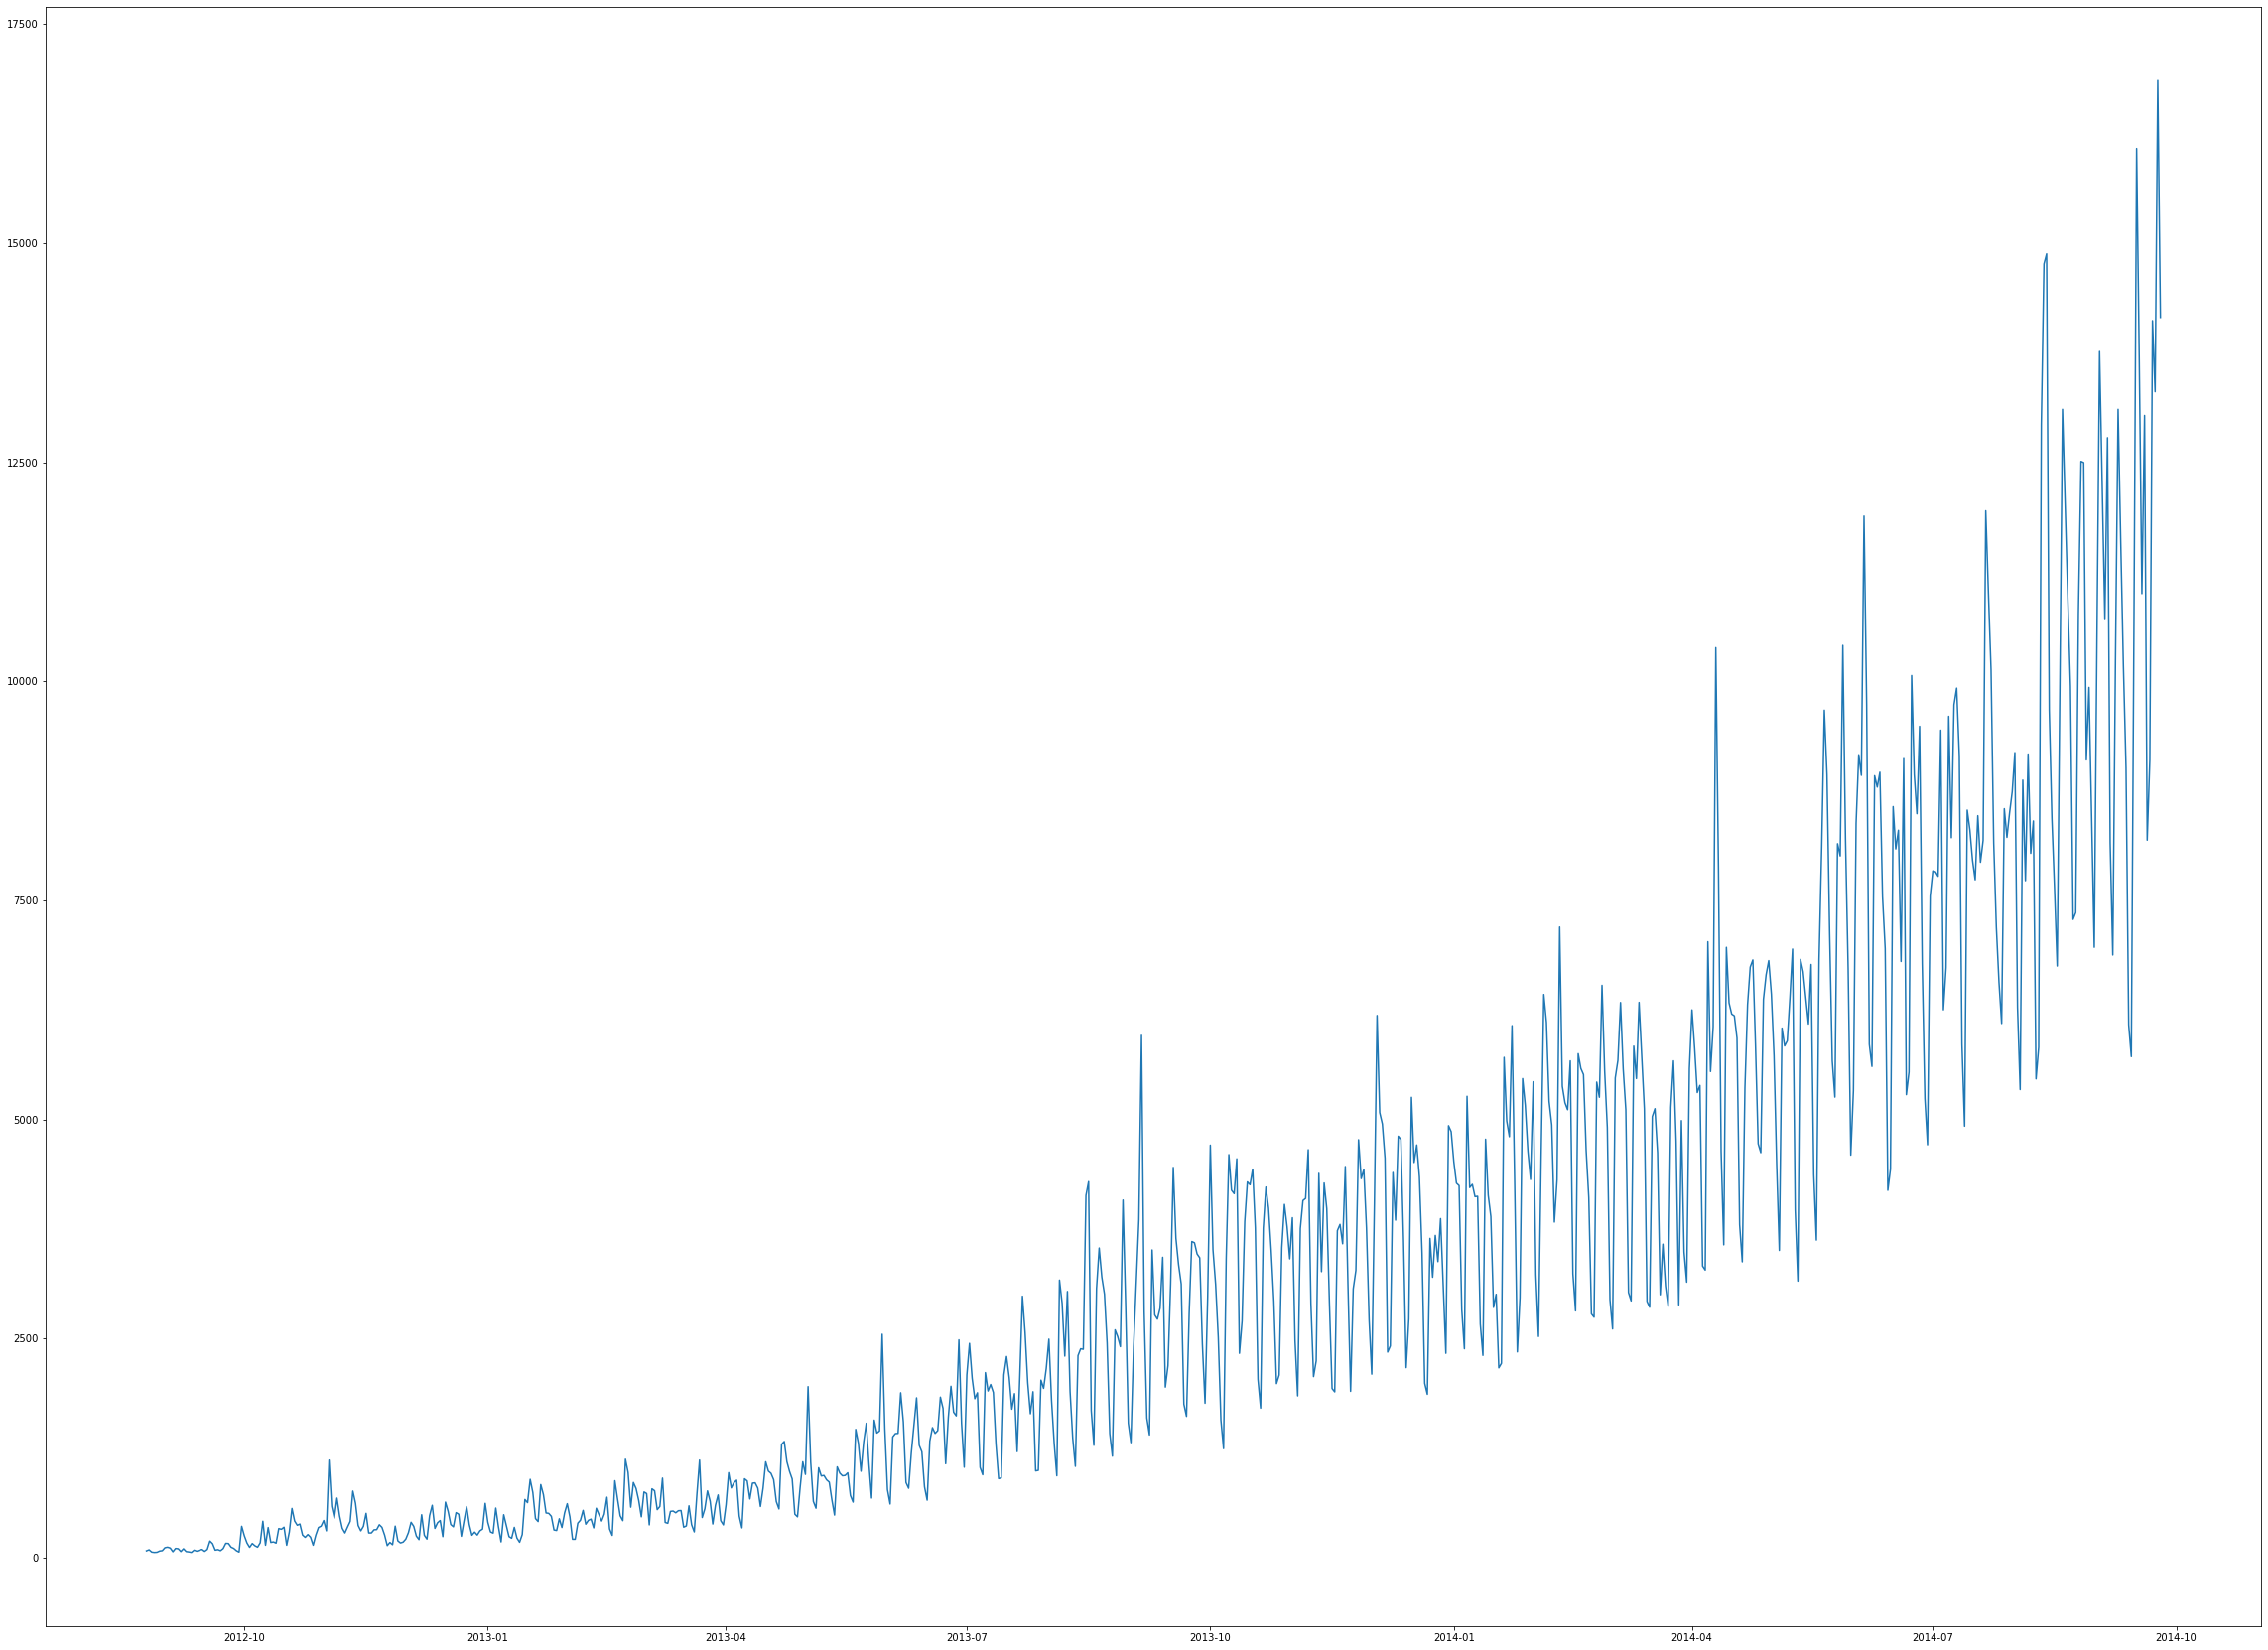

In [12]:
df=train_data.copy()
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df = df.set_index('date')

plt.figure(figsize=(40,30))
plt.plot(df.index, df.Count)

In [13]:
train_data["data"]="train"
test_data["data"]="test"
data=pd.concat([train_data,test_data])
data = data.reset_index().drop(columns="index")

In [14]:
data.columns

Index(['ID', 'Datetime', 'Count', 'data'], dtype='object')

In [15]:
def Regression(data):
    data['Date'] = pd.to_datetime(data['Datetime']).dt.strftime("%d-%m-%Y")
    data['Time'] = pd.to_datetime(data['Datetime']).dt.hour
    data=data.sort_values(["Date"])
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data["Quarter"] = data["Date"].dt.quarter
    data["Year"] = data["Date"].dt.year
    data["Month"] = data["Date"].dt.month 
    data['Day'] = data.Date.dt.weekday
    data['Month_Start'] = data.Date.apply(lambda x: 1 if x.is_month_start else 0)
    data['Month_End'] = data.Date.apply(lambda x: 1 if x.is_month_end else 0)
    data['Week_Start'] = data.Day.apply(lambda x: 1 if x == 0 or x == 1 else 0)
    data['Week_End'] = data.Day.apply(lambda x: 1 if x == 5 or x == 6 else 0)
    
    train_data = data[data["data"]=="train"]
    test_data = data[data["data"]=="test"]

    train_data["SI_Y"]=train_data["Count"]/train_data.groupby(["Year","Month","Time"])["Count"].transform(np.median)
    train_data["F_SI"]=train_data.groupby("Month")["SI_Y"].transform(np.mean)

    train_data["D_Seasonalised_trend"] = train_data["Count"]/train_data["F_SI"]    
    train_data["Level_index1"]=np.mean(train_data[(train_data.Year==2014)&(train_data.Quarter==1)]["Count"])/np.mean(train_data[(train_data.Year==2013)&(train_data.Quarter==4)]["Count"])

    numer1=np.mean(train_data[(train_data.Year==2014)&(train_data.Quarter==2)]["Count"])/np.mean(train_data[(train_data.Year==2014)&(train_data.Quarter==1)]["Count"])
    numer2=np.mean(train_data[(train_data.Year==2014)&(train_data.Quarter==3)]["Count"])/np.mean(train_data[(train_data.Year==2014)&(train_data.Quarter==2)]["Count"])

    train_data["Level_index2"]=np.mean([numer1,numer2])
    train_data=train_data.sort_values(["Date"])

    train_data["Deleveled_series"]=np.where(train_data.Date<='28-02-2013' , train_data["Count"]*train_data["Level_index1"],train_data["Count"])

    lm = linear_model.LinearRegression()
    X = np.array(train_data[["ID","Month_Start","Month_End","Week_Start","Week_End"]]) # In case of no extra variable in the dataset, remove the extra variable name from the list, then append the line with ".reshape(-1, 1)"
    Y = np.array(train_data["Deleveled_series"]).reshape(-1,1) 

    model = lm.fit(X,Y)
    
    Y_train_pred= Y*train_data.iloc[0]["Level_index2"]*np.array(train_data.iloc[0:len(Y)]["F_SI"]).reshape(-1,1)
    print("RMSE : ",np.sqrt(mean_squared_error(Y,Y_train_pred)))
    
    X_test=np.array(test_data[["ID","Month_Start","Month_End","Week_Start","Week_End"]]) # In case of no extra variable in the dataset, remove the extra variable name from the list, then append the line with ".reshape(-1, 1)"
    Y_test=model.predict(X_test)
    
    Pred1 = Y_test*train_data.iloc[0]["Level_index2"]*np.array(train_data.iloc[0:len(Y_test)]["F_SI"]).reshape(-1,1)
    
    plt.plot(train_data.index, train_data.Count)
    plt.plot(test_data.index, Pred1)

    test_data["Count"]=Pred1
    submit=test_data[["ID","Count"]]
    submit=submit.sort_values(["ID"])
    return(submit)

RMSE :  118.47342307981393


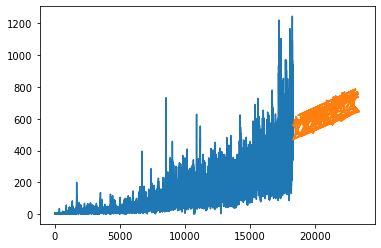

In [16]:
required_cols = [col for col in data.columns if col not in ['ID', 'Datetime',  'data']]


Result=pd.DataFrame()

for model in [Regression]:
    for i in required_cols:
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        to_func = data[['ID', 'Datetime',  'data', i]]
        to_func.columns=['ID', 'Datetime', 'data', 'Count']
        if model == Regression:
            Result_inter = model(to_func)
            Result_inter.name = model.__name__ + "_" +  i
            Result_inter.index=range(len(Result_inter))
            Result = pd.concat([Result, Result_inter], axis = 1)
        
        
Result.to_csv('Forecast.csv')



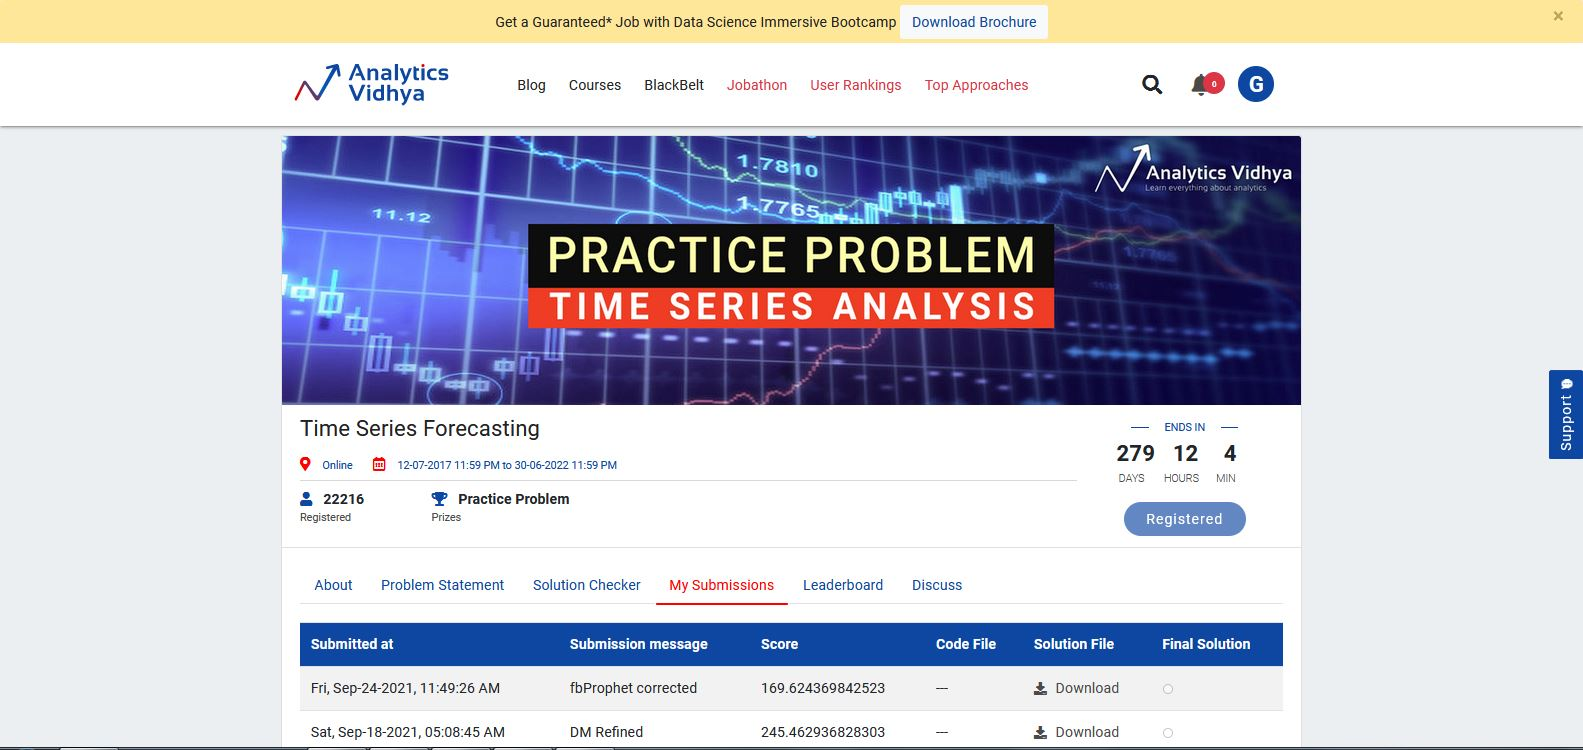

In [2]:
from IPython.display import Image
Image(filename='Score.JPG')